In [1]:
!pip3 install scanpy

In [2]:
import anndata as ad
import scanpy as sc
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, f_classif
from scipy.stats import mode
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from collections import Counter

In [3]:
adata = ad.read_h5ad('E9.5_E1S1.MOSTA.h5ad')

In [4]:
print(adata)


AnnData object with n_obs × n_vars = 5913 × 25568
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'annotation', 'Regulon - 2310011J03Rik', 'Regulon - 5730507C01Rik', 'Regulon - Alx1', 'Regulon - Alx3', 'Regulon - Alx4', 'Regulon - Ar', 'Regulon - Arid3a', 'Regulon - Arid3c', 'Regulon - Arnt2', 'Regulon - Arx', 'Regulon - Ascl1', 'Regulon - Atf1', 'Regulon - Atf4', 'Regulon - Atf5', 'Regulon - Atf6', 'Regulon - Atf7', 'Regulon - Bach1', 'Regulon - Bach2', 'Regulon - Barhl1', 'Regulon - Barx1', 'Regulon - Batf', 'Regulon - Bcl11a', 'Regulon - Bcl3', 'Regulon - Bcl6', 'Regulon - Bcl6b', 'Regulon - Bclaf1', 'Regulon - Bdp1', 'Regulon - Bhlha15', 'Regulon - Bhlhe22', 'Regulon - Bhlhe23', 'Regulon - Bhlhe41', 'Regulon - Bmyc', 'Regulon - Boll', 'Regulon - Bptf', 'Regulon - Brca1', 'Regulon - Brf1', 'Regulon - Brf2', 'Regulon - Bsx', 'Regulon - Cdx1', 'Regulon - Cdx2', 'Regulon - Cebpa', 'Regulon - Cebpz', 'Regulon - Chd1', 'Regulon - Clock', 'Re

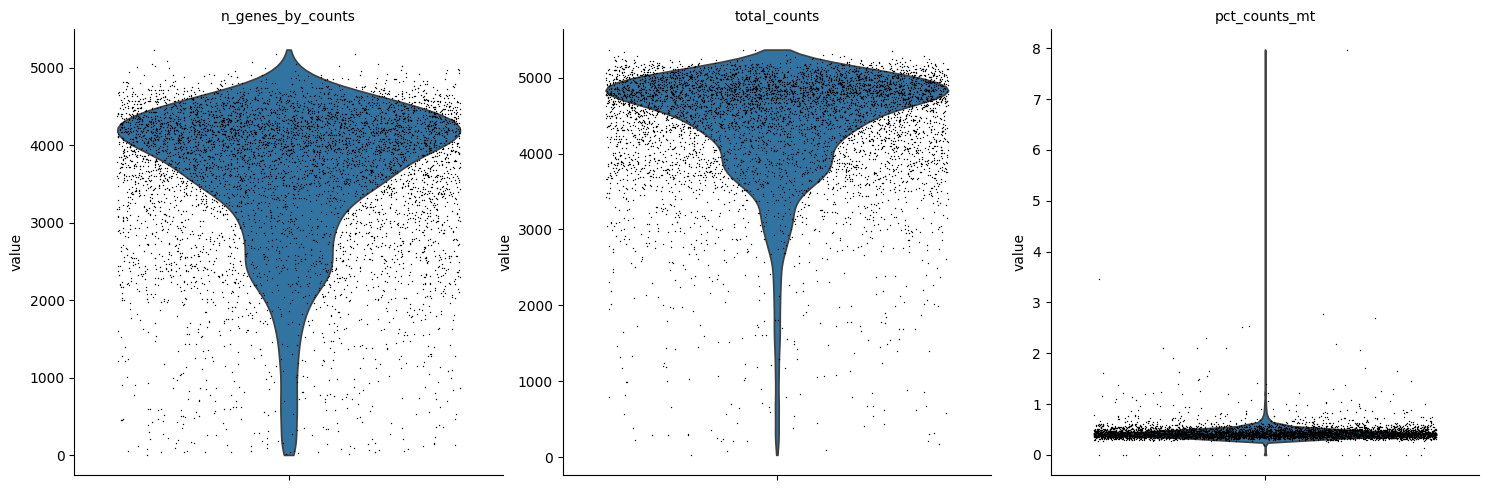

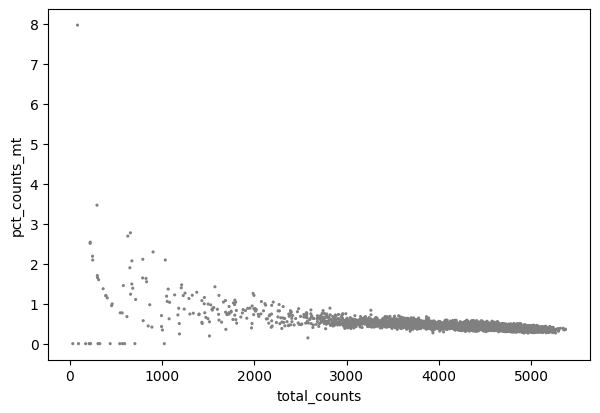

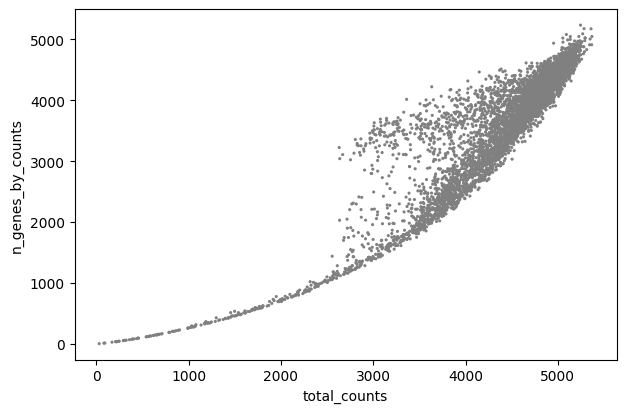

In [5]:
adata.var['mt'] = adata.var_names.str.startswith('mt-')
sc.pp.calculate_qc_metrics(adata, qc_vars=["mt"], percent_top=None, log1p=False, inplace=True)
sc.pl.violin(adata, ["n_genes_by_counts", "total_counts", "pct_counts_mt"], jitter=0.4, multi_panel=True)
sc.pl.scatter(adata, x="total_counts", y="pct_counts_mt")
sc.pl.scatter(adata, x="total_counts", y="n_genes_by_counts")

In [6]:
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)
adata = adata[adata.obs.pct_counts_mt < 2, :]

In [7]:
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

/Users/dejandraskovic/Desktop/Master/GI/Project/Genomics/.venv/lib/python3.11/site-packages/scanpy/preprocessing/_normalization.py:206: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [8]:
# Identify the highly variable genes
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
adata_hvg = adata[:, adata.var['highly_variable']]

In [9]:
# Regress and scale the data
sc.pp.regress_out(adata, ['total_counts', 'pct_counts_mt'])
sc.pp.scale(adata, max_value=10)

In [10]:
Y = adata.obs['annotation'].to_numpy()
cell_Indexes = adata.obs.index.to_numpy()

# Generate a permutation of index array
np.random.seed(42)  
indices = np.arange(adata.X.shape[0])
np.random.shuffle(indices)

# Shuffle X and Y and Cell_Indexes using the same indices
adata_shuffled = adata[indices].copy()
Y_shuffled = Y[indices]
cell_Indexes_shuffled = cell_Indexes[indices]

In [11]:
# Define the number of folds and L value
k_fold = 5
combination_num = 3

K_list = [3, 5, 7]
L_list = [2, 3, 4]

# Initialize StratifiedKFold and classifier
skf = StratifiedKFold(n_splits=k_fold)

classifier1 = SVC(kernel='rbf', C=1.0, gamma='scale')  
classifier2 = RandomForestClassifier(n_estimators=100, max_depth=None, max_features="sqrt")
classifier3 = KNeighborsClassifier(n_neighbors=10)
classifier4 = GradientBoostingClassifier(n_estimators=20, max_depth=5, learning_rate=1) 
classifier5 = LogisticRegression(penalty='l2', solver='lbfgs', max_iter=5000)  
classifier6 = RandomForestClassifier(n_estimators=200, max_depth=10, max_features="log2")
classifier7 = GradientBoostingClassifier(n_estimators=50, max_depth=3, learning_rate=0.5) 
classifiers = [classifier1, classifier2, classifier3, classifier4, classifier5, classifier6, classifier7]
classifiers_names = ["SVC", "Random Forest (max_depth=None)", "KNeighbors", "Gradient Boosting (n_estimators=20)", "LogisticRegression", 
                     "Random Forest (max_depth=10)", "Gradient Boosting (n_estimators=50)"]

In [12]:
scaler = StandardScaler()

for i in range(0,combination_num):
    K = K_list[i]
    L = L_list[i]

    # Initialize predictions dictionary with keys as cell indexes and values as empty lists or arrays of size K
    predictions = {index: np.empty(K, dtype=object) for index in cell_Indexes_shuffled}

    # Metrics storage
    accuracy_scores = []
    precision_scores = []
    recall_scores = []
    f1_scores = []

    # Metrics storage by model
    scores_by_model = {}

    # Training and prediction
    classifier_index = 0
    for classifier_index in range(0,K):

        accuracy_scores_models = []
        precision_scores_models = []
        recall_scores_models = []
        f1_scores_models = []

        for train_index, test_index in skf.split(adata_shuffled, Y_shuffled):
            adata_train = adata_shuffled[train_index].copy() 
            adata_test = adata_shuffled[test_index].copy()
            y_train =  Y_shuffled[train_index]
            y_test = Y_shuffled[test_index]
            cell_indexes_test = cell_Indexes_shuffled[test_index]

            pca = PCA(n_components=50, svd_solver='arpack')
            adata_train.obsm['X_pca'] = pca.fit_transform(adata_train.X)
            adata_test.obsm['X_pca'] = pca.transform(adata_test.X)

            X_train = scaler.fit_transform(np.hstack([adata_train.obsm['X_pca'], adata_train.obsm['spatial']]))
            X_test = scaler.fit_transform(np.hstack([adata_test.obsm['X_pca'], adata_test.obsm['spatial']]))

            classifier = classifiers[classifier_index]

            # Train the model
            classifier.fit(X_train, y_train)
            
            # Predict on the test set
            preds = classifier.predict(X_test)

            # Store predictions in the dictionary using the cell indexes
            for idx, cell_index in enumerate(cell_indexes_test):
                predictions[cell_index][classifier_index] = preds[idx]
            
            # Evaluate predictions
            acc = accuracy_score(y_test, preds)
            prec = precision_score(y_test, preds, average='macro', zero_division=1)
            rec = recall_score(y_test, preds, average='macro')
            f1 = f1_score(y_test, preds, average='macro')

            # Print metrics
            print(f"{classifiers_names[classifier_index]} - Accuracy: {acc}, Precision: {prec}, Recall: {rec}, F1 Score: {f1}")

            # Append metrics to lists for average calculation later
            accuracy_scores.append(acc)
            precision_scores.append(prec)
            recall_scores.append(rec)
            f1_scores.append(f1)

            accuracy_scores_models.append(acc)
            precision_scores_models.append(prec)
            recall_scores_models.append(rec)
            f1_scores_models.append(f1)

        # Store average scores by model
        scores_by_model[classifiers_names[classifier_index]] = [np.mean(accuracy_scores_models), np.mean(precision_scores_models), np.mean(recall_scores_models), np.mean(f1_scores_models)]

        print("--------------------------------------------------------------------------------------------------------------------------------------------")

    # Pick best model by f1 score
    best_model_by_f1 = sorted(scores_by_model.items(), key=lambda x: x[1][3], reverse=True)[0]
    best_model_name = best_model_by_f1[0]
    best_model_f1_score = best_model_by_f1[1][3]
    print(f"Best model by F1 score: {best_model_name} with F1 Score: {best_model_f1_score}")
        

    # Calculate and print average scores
    print(f"Averages for all models used with K={K} and L={L}:")
    print("Average Accuracy:", np.mean(accuracy_scores))
    print("Average Precision:", np.mean(precision_scores))
    print("Average Recall:", np.mean(recall_scores))
    print("Average F1 Score:", np.mean(f1_scores))

    predicted_annotations = adata.obs['annotation'].copy()

    number_of_changed = 0
    # Process each cell index and its predictions
    for cell_index, preds in predictions.items():
        # Count occurrences of each annotation
        pred_count = Counter(preds)

        most_common_pred, count = pred_count.most_common(1)[0]

        
        if count > L:
            if adata.obs.loc[cell_index, 'annotation'] != most_common_pred:
                predicted_annotations.loc[cell_index] = most_common_pred
                number_of_changed += 1

    print(f"Number of annotations changed for K={K}, L={L}: {number_of_changed}")
    print("<><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><>")

    adata.obs[f'annotation_K{K}_L{L}'] = predicted_annotations



SVC - Accuracy: 0.9267461669505963, Precision: 0.925432452478346, Recall: 0.920422092096309, F1 Score: 0.9218649365847709
SVC - Accuracy: 0.9131175468483816, Precision: 0.9192713361180358, Recall: 0.9071340339301486, F1 Score: 0.9124113558691843
SVC - Accuracy: 0.9301533219761499, Precision: 0.9324295166516966, Recall: 0.9206688875314839, F1 Score: 0.9259236383178386
SVC - Accuracy: 0.9224211423699915, Precision: 0.9291949906237176, Recall: 0.9178593570461757, F1 Score: 0.9231351830176084
SVC - Accuracy: 0.9326513213981245, Precision: 0.9379630246049934, Recall: 0.9119009106317116, F1 Score: 0.9235480217078972
--------------------------------------------------------------------------------------------------------------------------------------------
Random Forest (max_depth=None) - Accuracy: 0.9403747870528109, Precision: 0.9453684637305867, Recall: 0.92724425346277, F1 Score: 0.9348704988081704
Random Forest (max_depth=None) - Accuracy: 0.9293015332197615, Precision: 0.9361191138937128

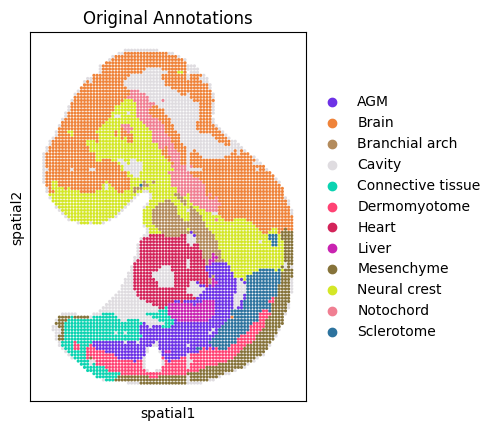

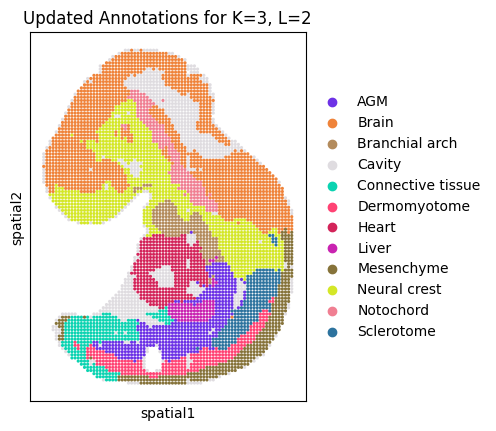

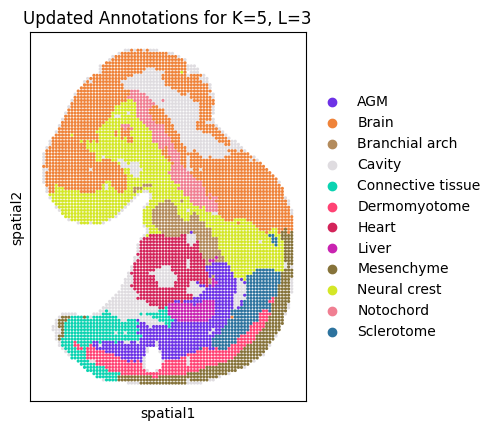

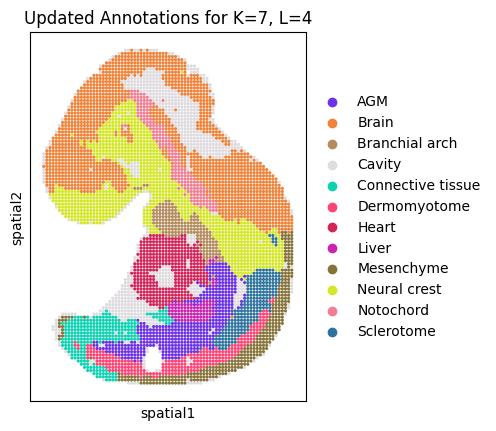

In [13]:
spot_size = 1.0  # Adjust this value as needed
existing_palette = adata.uns['annotation_colors']
sc.pl.spatial(adata, color='annotation', title=f"Original Annotations", spot_size=spot_size)

for i in range(0,combination_num):
    K = K_list[i]
    L = L_list[i]
    
    adata.uns[f'annotation_K{K}_L{L}_colors'] = existing_palette
    sc.pl.spatial(adata, color=f'annotation_K{K}_L{L}', title=f"Updated Annotations for K={K}, L={L}", spot_size=spot_size)